In [20]:
# Import necessary libraries
import sys
import random
import torch
import os
import math
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set path to fix relative imports
sys.path.append("..")
from data import TimeFusionDataset
from timefusion import TimeFusion, EarlyStopper

In [4]:
# Import dataset
train_data = pd.read_csv("../../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:30]
test_data = test_data.iloc[:,:30]
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)

# Standardize data
means = train_data.mean()
stds = train_data.std()
train_data = (train_data-means)/stds
test_data = (test_data-means)/stds

# Randomly remove 30% of data to make irregular
np.random.seed(0) # Set random seed to make result reproducible
#remove = 0.30
remove = 0

# Training data 
train_mask = np.full(train_data.size, False)
train_mask[:int(train_data.size*remove)] = True
np.random.shuffle(train_mask)
train_data = train_data.mask(train_mask.reshape(train_data.shape))

# Test data
test_mask = np.full(test_data.size, False)
test_mask[:int(test_data.size*remove)] = True
np.random.shuffle(test_mask)
test_data = test_data.mask(test_mask.reshape(test_data.shape))

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    #device = torch.device("cpu")
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [13]:
# Define some common variables
context_length = 48 
prediction_length = 24

encodings = [
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24)),
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*7)),
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*30)),
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*90)),
    # lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*365)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*7)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*30)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*90)),
    # lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*365)),
]

# Create each dataset
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
    pin_memory=True,
    pin_memory_device="cuda:0"
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
    pin_memory=True,
    pin_memory_device="cuda:0"
)



In [17]:
predictor = TimeFusion(
    context_length = context_length,
    prediction_length = prediction_length,
    timeseries_shape = (len(train_dataset.time_series),train_dataset.time_series[0].shape[1]), 
    num_encoder_layers=3,
    d_model=512,
    nhead=32,
    dim_feedforward=1024,
    diff_steps=100,
    device = device,
)

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/TimeFusion/visualisation_notebooks/../diffusion.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [10]:
# Load weights
#predictor.load_state_dict(torch.load("../weights/2023-04-12-20-02-45",map_location=torch.device('cpu')))
#predictor.eval()
predictor.load_state_dict(torch.load("../weights/2023-04-12-20-02-45",map_location=torch.device('cpu')).state_dict())

TypeError: Expected state_dict to be dict-like, got <class 'timefusion.TimeFusion'>.

In [19]:
sample_index = 240

timestamps = []
for col in range(test_dataset.indices.shape[1]):
    timestamps.append(list(test_data.iloc[sample_index:,col].dropna().index[:predictor.prediction_length]))

timestamps = np.array(timestamps)

samples = predictor.sample(
    data = test_dataset,
    sample_indices = timestamps,
    num_samples = 100,
    timestamp_encodings = encodings
)


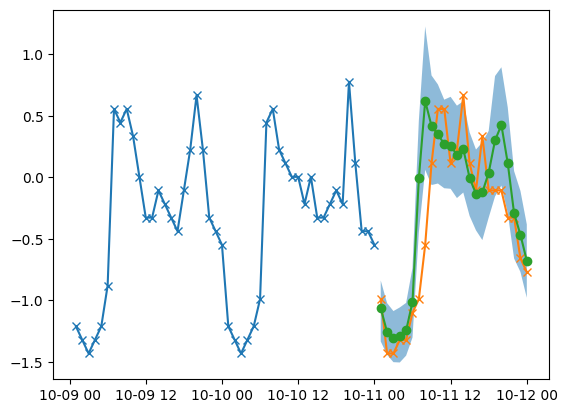

In [22]:
# Plot the samples
confidence = 0.1

samples_cpu = samples.cpu()
samples_cpu[:,0,:], _= torch.sort(samples_cpu[:,0,:],dim=0)
samples_cpu[:,1,:], _ = torch.sort(samples_cpu[:,1,:],dim=0)

plt.figure()
plt.plot(test_data.iloc[:sample_index,1].dropna().iloc[-predictor.context_length:],"-x")
plt.plot(test_data.iloc[sample_index:,1].dropna().iloc[:predictor.prediction_length],"-x")
plt.fill_between(timestamps[1], samples_cpu[int(confidence*samples_cpu.shape[0]),1,:], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),1,:],alpha=0.5)
plt.plot(timestamps[1],torch.mean(samples.cpu(),axis=0)[1],"-o")

# plt.figure()
# plt.plot(val_data.data_copy.iloc[:sample_index,1].dropna().iloc[-predictor.context_length:],"-x")
# plt.plot(val_data.data_copy.iloc[sample_index:,1].dropna().iloc[:predictor.prediction_length],"-x")
# plt.fill_between(timestamps[1], samples_cpu[int(confidence*samples_cpu.shape[0]),1,:], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),1,:],alpha=0.5)
# plt.plot(timestamps[1],torch.mean(samples.cpu(),axis=0)[1],"-o")
